In [ ]:
# Customer Segmentation for E-Commerce Using RFM Analysis
**Objective**: Segment customers based on Recency, Frequency, and Monetary (RFM) metrics to inform targeted marketing strategies.
**Dataset**: UCI Online Retail Dataset (Online_Retail.xlsx)
**Tools**: Python, pandas, scikit-learn, matplotlib, seaborn

C:\Users\PC\AppData\Local\Temp\ipykernel_10948\291490967.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='Set3')


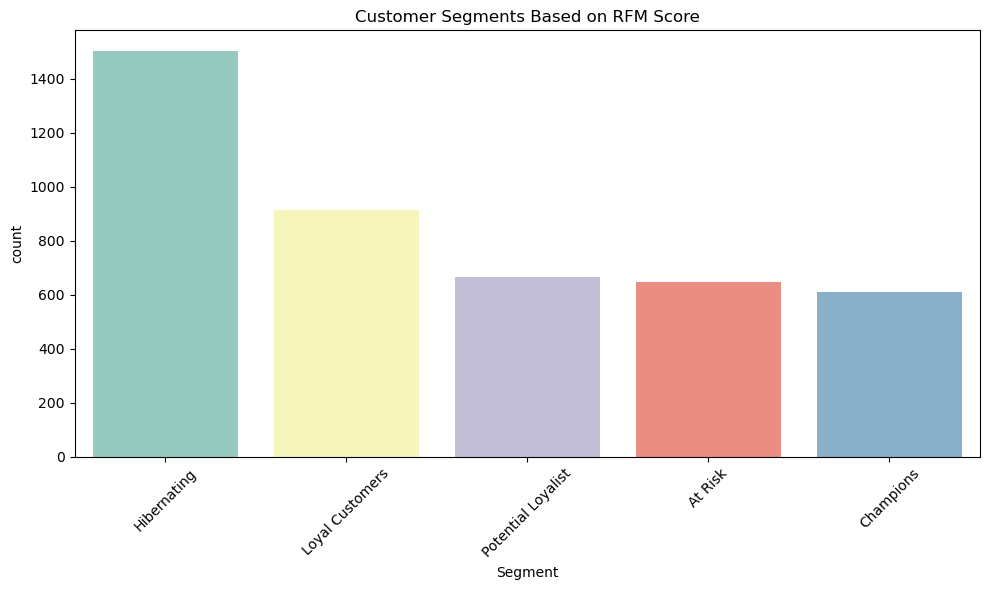

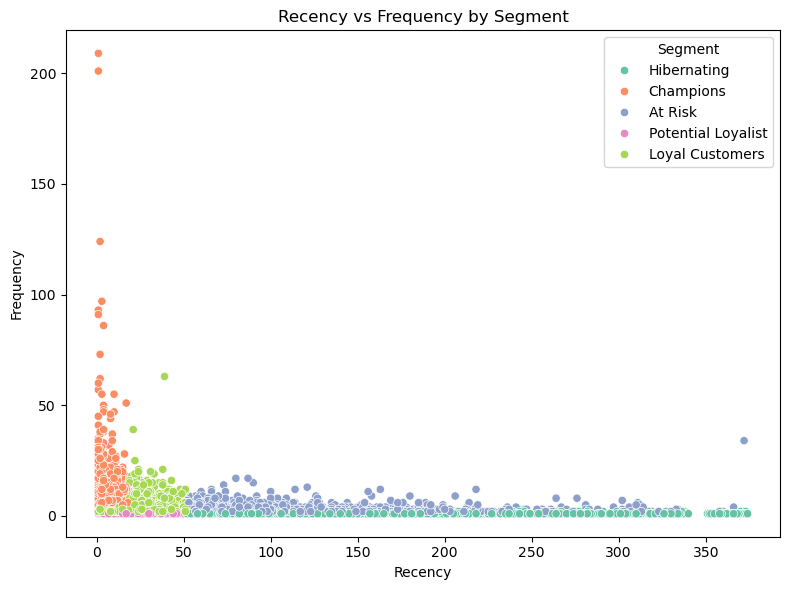


Cluster Summary:
          Recency  Frequency  Monetary
Cluster                              
0           43.7        3.7    1359.0
1          248.1        1.6     480.6
2            7.4       82.5  127338.3
3           15.5       22.3   12709.1


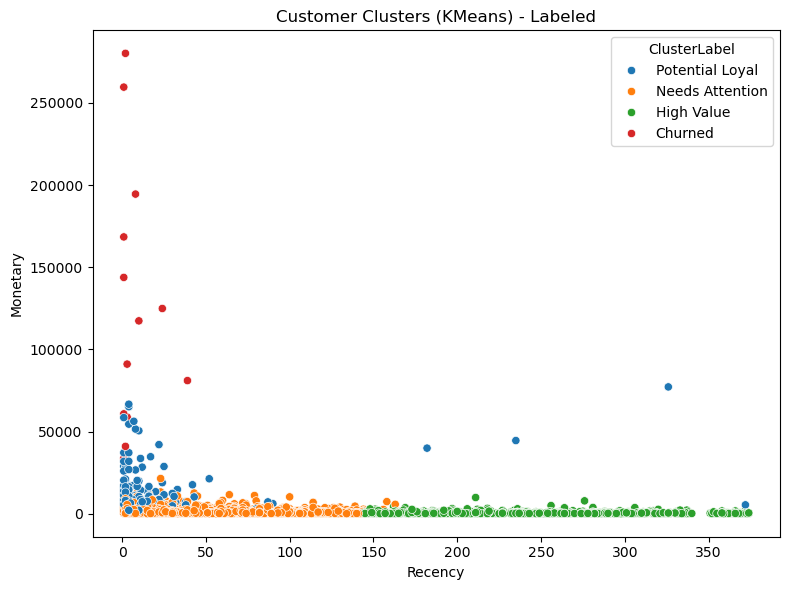

In [16]:
# --- Step 1: Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- Step 2: Load Data ---
df = pd.read_excel(r"E:\project\online+retail\Online_Retail.xlsx")

# --- Step 3: Data Cleaning ---
df.dropna(subset=['CustomerID'], inplace=True)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# --- Step 4: Calculate RFM Metrics ---
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
df['TotalSum'] = df['Quantity'] * df['UnitPrice']

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalSum': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm[rfm['Monetary'] > 0]

# --- Step 5: RFM Scoring using Quantiles ---
rfm['R_quartile'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_quartile'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_quartile'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

rfm['RFM_Score'] = (rfm['R_quartile'].astype(str) +
                    rfm['F_quartile'].astype(str) +
                    rfm['M_quartile'].astype(str))

# --- Step 6: Define Segments Based on Scores ---
def segment_label(score):
    r, f, m = map(int, list(score))
    if r >= 4 and f >= 4:
        return 'Champions'
    elif r >= 3 and f >= 3:
        return 'Loyal Customers'
    elif r >= 3 and f <= 2:
        return 'Potential Loyalist'
    elif r <= 2 and f >= 3:
        return 'At Risk'
    elif r <= 2 and f <= 2:
        return 'Hibernating'
    else:
        return 'Others'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_label)

# --- Step 7: Segment Distribution Plot ---
plt.figure(figsize=(10, 6))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='Set3')
plt.title('Customer Segments Based on RFM Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(r"E:\project\Project_one\segment_distribution.png")
plt.show()

# --- Step 8: Recency vs Frequency by Segment ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Segment', palette='Set2')
plt.title("Recency vs Frequency by Segment")
plt.tight_layout()
plt.savefig(r"E:\project\Project_one\recency_vs_frequency.png")
plt.show()

# --- Step 9: KMeans Clustering ---
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# --- Step 10: Rename Clusters with Meaningful Labels ---
# Optional: You may change these based on your actual cluster stats
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)
print("\nCluster Summary:\n", cluster_summary)

cluster_labels = {
    0: 'Needs Attention',
    1: 'High Value',
    2: 'Churned',
    3: 'Potential Loyal'
}
rfm['ClusterLabel'] = rfm['Cluster'].map(cluster_labels)

# --- Step 11: Visualize KMeans Clusters with Labels ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='ClusterLabel', palette='tab10')
plt.title("Customer Clusters (KMeans) - Labeled")
plt.tight_layout()
plt.savefig(r"E:\project\Project_one\kmeans_clusters_labeled.png")
plt.show()

# --- Step 12: Save Final RFM Data to Excel ---
rfm.to_excel(r"E:\project\Project_one\RFM_Segments_Final_Labeled.xlsx", index=True)
